In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import windIO
import foam
import wind

In [3]:
# workDir = "D:/OneDrive - The University of Western Ontario/Documents/PhD/Thesis/01-revisitOfWindLoadEvaluation/01.02_Re_effect/Data/FFS/"
workDir = "D:/tempData_depot/simData_FFS/"
overwrite = True

# Pre-processing
### Separated shear layer

In [4]:
yLoc = 0
file = workDir+"probes.SSL.y_"+str(yLoc)

H = 0.08
xMin, xMax = 0.0, 2.0*H
zMin, zMax = 1.001*H, 2.0*H
d = 0.02*H
Nx, Nz = int(np.round((xMax-xMin)/d,0)), int(np.round((zMax-zMin)/d,0))

x, z = np.meshgrid(np.linspace(xMin, xMax, Nx), np.linspace(zMin, zMax, Nz))
x = x.flatten()
z = z.flatten()
y = np.ones_like(x)*yLoc

pts = np.column_stack((x,y,z))

print(f"Num in x: {Nx}, Num in z: {Nz}, Total: {Nx*Nz}")
# foam.writeProbeDict(file,pts,overwrite=overwrite)

Num in x: 100, Num in z: 50, Total: 5000


### Frontal BL

In [5]:
yLoc = 0
file = workDir+"probes.FBL.y_"+str(yLoc)

H = 0.08
xMin, xMax = 0.0001*H, 0.1*H
zMin, zMax = 0.0002, 1.0*H
d = 0.02*H
Nx, Nz = 50, int(np.round((zMax-zMin)/d,0))

X = -1.0*np.flip(np.logspace(np.log10(xMin), np.log10(xMax), Nx))

x, z = np.meshgrid(X, np.linspace(zMin, zMax, Nz))
x = x.flatten()
z = z.flatten()
y = np.ones_like(x)*yLoc

pts = np.column_stack((x,y,z))

print(f"Num in x: {Nx}, Num in z: {Nz}, Total: {Nx*Nz}")
# foam.writeProbeDict(file,pts,overwrite=overwrite)

Num in x: 50, Num in z: 50, Total: 2500


### Surface pressure

In [6]:
yLoc = 0
file = workDir+"probes.surfPres.y_"+str(yLoc)

H = 0.08
d = 0.02*H
xMax = 6.0*H
Nx, Nz = int(np.round(xMax/d,0)), int(np.round(H/d,0))

z1 = np.linspace(0.001, 0.99*H, Nz)
x1 = np.ones_like(z1)*-0.0001

x2 = np.linspace(0.0,xMax,Nx)
z2 = np.ones_like(x2)*H

x = np.append(x1,x2)
z = np.append(z1,z2)

y = np.ones_like(x)*yLoc

pts = np.column_stack((x,y,z))

print(f"Num in x: {Nx}, Num in z: {Nz}, Total: {Nx+Nz}")

# foam.writeProbeDict(file,pts,overwrite=overwrite,fields=['p'])

Num in x: 300, Num in z: 50, Total: 350


# Read and process data

In [97]:
caseName = "FFS_ABL_01"
caseDir = workDir+caseName+"/"
prof_ABL_03 = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H)
prof_ABL_03.name = "ABL (x=-0.3)"

caseName = "FFS_ABL_01"
caseDir = workDir+caseName+"/"
prof_ABL_05 = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.5', H=H)
prof_ABL_05.name = "ABL (x=-0.5)"

caseName = "FFS_SBL_01"
caseDir = workDir+caseName+"/"
prof_SBL = foam.readVelProfile(caseDir=caseDir, probeName='probes.zProfile.x-0.3', H=H)
prof_SBL.name = "SBL"


Processing OpenFOAM case:	D:/tempData_depot/simData_FFS/FFS_ABL_01/
Probe read from:		D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.zProfile.x-0.3
  >> Reading probe data ...
           reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.zProfile.x-0.3/0.426/U
                61 probes with 1057 time steps and shape of data: (1057, 61, 3)
           reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.zProfile.x-0.3/0.637/U
                61 probes with 1076 time steps and shape of data: (1076, 61, 3)
           reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.zProfile.x-0.3/0.852/U
                61 probes with 740 time steps and shape of data: (740, 61, 3)
           reading U from: D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.zProfile.x-0.3/0.999/U
                61 probes with 981 time steps and shape of data: (981, 61, 3)
           reading U from: D:/tempD

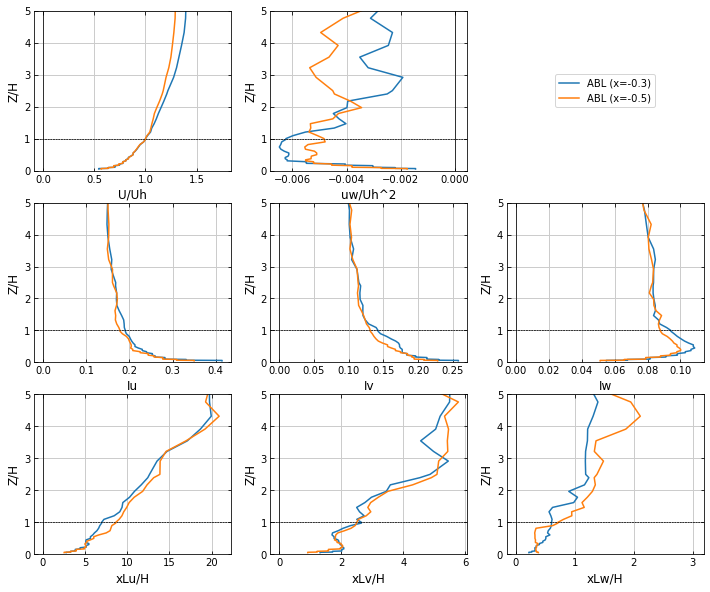

5.796157834293896


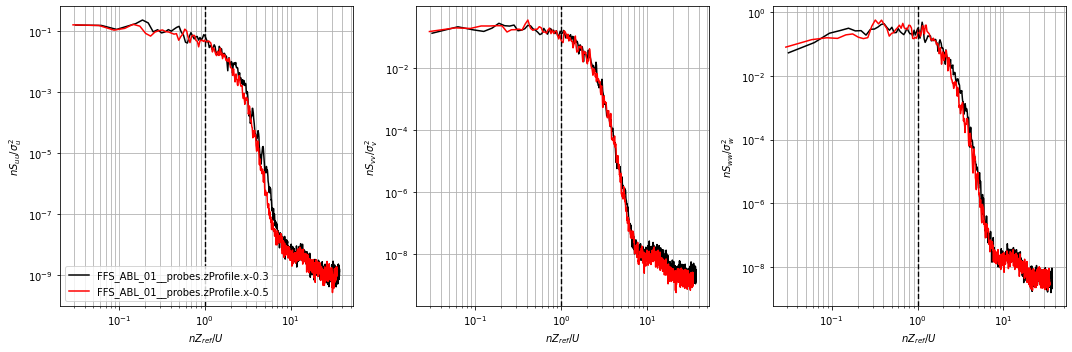

In [119]:
profs = wind.Profiles([prof_ABL_03, prof_ABL_05])
profs.plotProfile_basic2(yLimits=[0,5])
profs.plotSpectra(normU='sigUi')

print(prof_ABL_05.Uh)
foam.meshSizeFromCutoffFreq

(61, 18858)
(18857,)


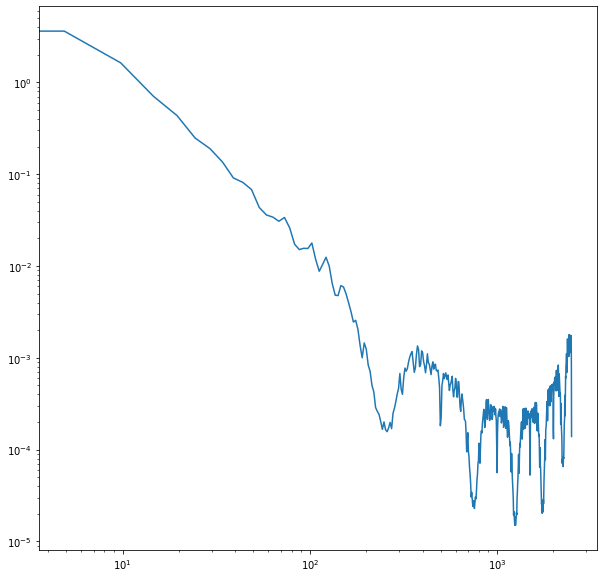

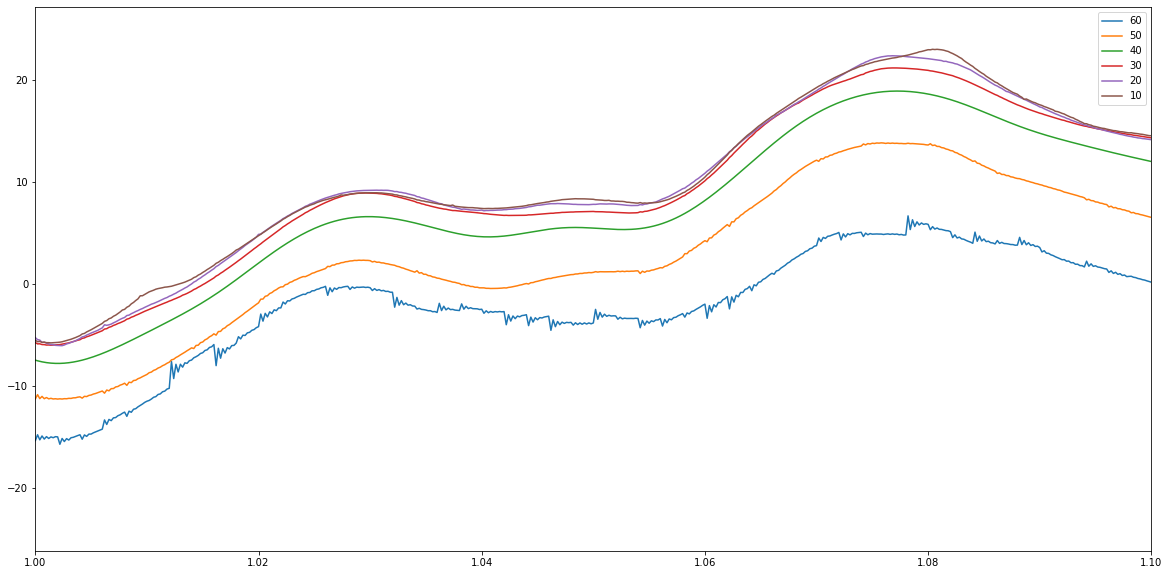

In [106]:
import scipy.signal as signal

print(prof_ABL_03.pOfT.shape)
print(prof_ABL_03.t.shape)

p = prof_ABL_03.pOfT[40,:-1]
freq, Sp = signal.welch(p-np.mean(p), fs=1/prof_ABL_03.dt, nperseg=1024, noverlap=512, detrend=False, scaling='density')

# highpass filter the pressure at 100Hz
p_new = signal.filtfilt(b=signal.butter(3, 100/(1/prof_ABL_03.dt), btype='high', output='ba')[0], a=signal.butter(3, 100/(1/prof_ABL_03.dt), btype='high', output='ba')[1], x=p-np.mean(p))
p_cleaned = p - p_new

plt.figure(figsize=(10,10))
plt.loglog(freq, Sp)
plt.show()

plt.figure(figsize=(20,10))
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[60,:-1]-p_new, label='60')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[50,:-1]-p_new, label='50')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[40,:-1]-p_new, label='40')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[30,:-1]-p_new, label='30')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[20,:-1]-p_new, label='20')
plt.plot(prof_ABL_03.t, prof_ABL_03.pOfT[10,:-1]-p_new, label='10')
# plt.plot(prof_ABL_03.t, p, label='unfiltered')
# plt.plot(prof_ABL_03.t, p_new, label='filtered')
# plt.plot(prof_ABL_03.t, p_cleaned, label='cleaned')
plt.legend()
plt.xlim([1,1.1])
plt.show()

In [114]:
caseName = "FFS_ABL_01"
caseDir = workDir+caseName+"/"
probes_surf,time_surf,pressure_surf = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.surfPres.y_0')

caseName = "FFS_ABL_01"
caseDir = workDir+caseName+"/"
probes_prof,time_prof,pressure_prof = foam.readSurfacePressure(caseDir=caseDir, probeName='probes.zProfile.x-0.3')

# lowpass filter the pressure
# pressure = wind.lowpass(pressure, 0.1, 1/0.02, order=3)

Processing OpenFOAM case:	D:/tempData_depot/simData_FFS/FFS_ABL_01/
Probe read from:		D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.surfPres.y_0
  >> Reading probe data ...
           reading p from: D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.surfPres.y_0/0.06/p
                350 probes with 258 time steps and shape of data: (258, 350)
           reading p from: D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.surfPres.y_0/0.111/p
                350 probes with 673 time steps and shape of data: (673, 350)
           reading p from: D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.surfPres.y_0/0.245/p
                350 probes with 906 time steps and shape of data: (906, 350)
           reading p from: D:/tempData_depot/simData_FFS/FFS_ABL_01//postProcessing/probes.surfPres.y_0/0.426/p
                350 probes with 1057 time steps and shape of data: (1057, 350)
           reading p from: D:/tempData_depot/simData

(18856, 350)
(18858,)


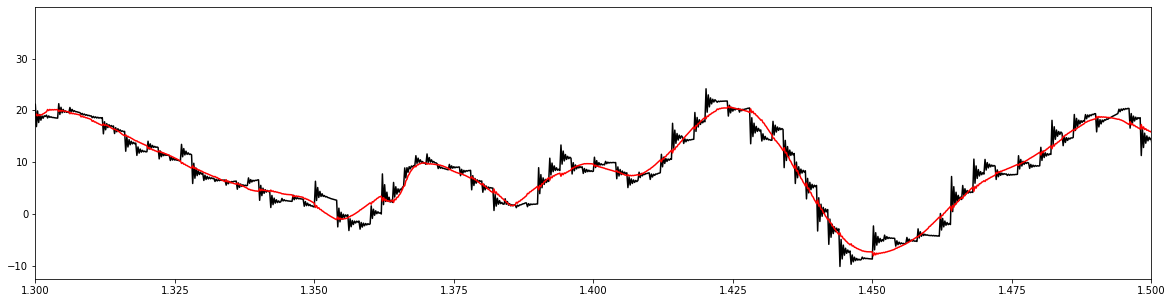

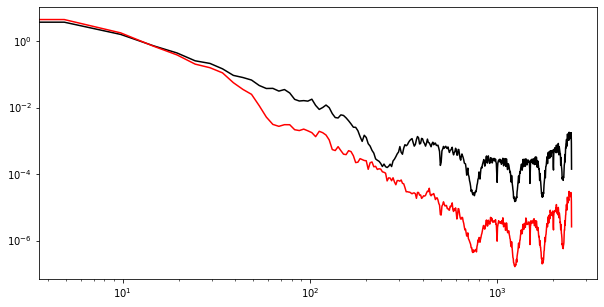

In [118]:
idx = 8
# meanP = np.mean(pressure,axis=0)
# stdP = np.std(pressure,axis=0)

import scipy.signal as signal
dt = time_surf[1]-time_surf[0]

p = pressure_prof[:,idx]

# highpass filter the pressure at 100Hz
p_new = signal.filtfilt(b=signal.butter(3, 100/(1/prof_ABL_03.dt), btype='high', output='ba')[0], a=signal.butter(3, 100/(1/prof_ABL_03.dt), btype='high', output='ba')[1], x=p-np.mean(p))
p_cleaned = p - p_new

p_surf = pressure_surf[:,idx]
p_surf_new = p_surf - p_new[:len(time_surf)]
freq, Sp = signal.welch(p-np.mean(p), fs=1/prof_ABL_03.dt, nperseg=1024, noverlap=512, detrend=False, scaling='density')
freq_new, Sp_new = signal.welch(p_surf_new-np.mean(p_surf_new), fs=1/prof_ABL_03.dt, nperseg=1024, noverlap=512, detrend=False, scaling='density')

print(pressure_surf.shape)
print(p_new.shape)

plt.figure(figsize=(20,5))
plt.plot(time_surf,p_surf, '-k', label='orig')
plt.plot(time_surf,p_surf_new, '-r', label='filtered')
plt.xlim([1.3,1.5])
plt.show()

plt.figure(figsize=(10,5))
plt.loglog(freq,Sp, '-k')
plt.loglog(freq_new,Sp_new, '-r')
plt.show()
